In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.347713
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ At the beginning of training, before any learning has taken place, we anticipate that the initial loss will be approximately equal to -log(0.1). This expectation arises because, in the CIFAR-10 dataset with ten classes, each class is equally likely to be chosen, resulting in a 0.1 probability for the correct class. The softmax loss is essentially the negative logarithm of this probability, which yields -log(0.1)



In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.101299 analytic: 0.101299, relative error: 1.202176e-07
numerical: 1.001526 analytic: 1.001526, relative error: 4.890997e-09
numerical: -1.137471 analytic: -1.137471, relative error: 2.660656e-08
numerical: 1.897927 analytic: 1.897927, relative error: 2.339798e-08
numerical: -0.890519 analytic: -0.890519, relative error: 2.699743e-08
numerical: -0.578125 analytic: -0.578126, relative error: 6.979492e-09
numerical: 0.682306 analytic: 0.682306, relative error: 4.525685e-08
numerical: 0.141387 analytic: 0.141387, relative error: 1.088888e-07
numerical: -0.684046 analytic: -0.684046, relative error: 4.192710e-08
numerical: -0.149372 analytic: -0.149372, relative error: 1.419782e-07
numerical: -0.702057 analytic: -0.702057, relative error: 2.676690e-08
numerical: 0.459252 analytic: 0.459252, relative error: 6.931593e-08
numerical: 0.124031 analytic: 0.124031, relative error: 3.891745e-08
numerical: -1.111487 analytic: -1.111487, relative error: 1.153439e-08
numerical: -0.870222

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.347713e+00 computed in 0.095631s
vectorized loss: 2.347713e+00 computed in 0.013473s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-8, 2e-7, 1e-7, 2e-6, 3e-5]
regularization_strengths = [1e3, 3.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# This is simply doing a grid search over hyperparameters.
# To find the optimal lr and reg strength we have to create 2 loops to figure out the best hyperparameters to find the best softmax classifier.
best_learning_rate = 0
best_reg_strength = 0
# Iterate over different combinations of hyperparameters
for lr in learning_rates:
    for reg in regularization_strengths:
        # Creating a Softmax classifier instance
        softmax = Softmax()

        # Training the Softmax classifier on the training data for 1500 iterations
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)

        # Predicting on the training and validation sets
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)

        # Calculating the accuracies
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)

        # Storing the results in a dictionary so that we can compare the results of this version of the classifier with these set of hyper params to other models.
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Checking if this is the best validation accuracy so far and is yes then assigning to get the best
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
            best_learning_rate = lr
            best_reg_strength = reg
print(f"Best Pair of lr and reg is (lr,reg):{(best_learning_rate,best_reg_strength)}")

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 36.316609
iteration 100 / 1500: loss 36.073047
iteration 200 / 1500: loss 35.233692
iteration 300 / 1500: loss 34.820098
iteration 400 / 1500: loss 34.351820
iteration 500 / 1500: loss 34.071754
iteration 600 / 1500: loss 33.334860
iteration 700 / 1500: loss 33.652979
iteration 800 / 1500: loss 33.499578
iteration 900 / 1500: loss 33.097452
iteration 1000 / 1500: loss 32.952140
iteration 1100 / 1500: loss 32.533762
iteration 1200 / 1500: loss 32.347198
iteration 1300 / 1500: loss 32.311144
iteration 1400 / 1500: loss 32.274609
iteration 0 / 1500: loss 1080.482646
iteration 100 / 1500: loss 939.186610
iteration 200 / 1500: loss 816.718685
iteration 300 / 1500: loss 709.997798
iteration 400 / 1500: loss 617.140955
iteration 500 / 1500: loss 536.602866
iteration 600 / 1500: loss 466.622819
iteration 700 / 1500: loss 405.729725
iteration 800 / 1500: loss 353.035940
iteration 900 / 1500: loss 306.743714
iteration 1000 / 1500: loss 266.856176
iteration 1100 / 1500: l

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:128: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax_probs [np.arange(no_train), y]) )


iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1515.635159
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:139: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:139: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf


/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:141: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W


iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
Best Pair of lr and reg is (lr,reg):(2e-06, 1000.0)
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.173980 val accuracy: 0.177000
lr 1.000000e-08 reg 3.500000e+04 train accuracy: 0.203408 val accuracy: 0.227000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.208265 val accuracy: 0.200000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.269939 val accuracy: 0.295000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.325163 val accuracy: 0.340000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.300980 val accuracy: 0.323000
lr 2.000000e-07 reg 1.000000e+03 train accuracy: 0.313776 val accuracy: 0.305000
lr 2.000000e-07 reg 3.500000e+04 train accuracy: 0.315714 val accuracy: 0.335000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.301612 val accuracy: 0.317000
lr 2.000000e-06 reg 1.000000e+03 train accuracy: 0.396796 val accuracy: 0.395000
lr 2.00000

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.395000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
True.


$\color{blue}{\textit Your Explanation:}$ In the case of the SVM loss, loss for each data point is determined by how close it is to the correct classification margin. If a new data point is added that is correctly classified with a margin greater than 1 (in linear SVM case), it would not contribute to the loss at all because the hinge loss for that data point would be zero. Therefore, adding such a data point would leave the overall training loss unchanged.

In contrast, the Softmax classifier computes the loss for each data point based on the probabilities assigned to all classes. The loss depends not only on the correctness of the classification but also on the confidence of the classifier's prediction. If a new data point is added and it has a different ground truth label, it would contribute to the Softmax loss, and this contribution would likely change the overall training loss. So, adding a new data point could potentially change the overall Softmax classifier loss.



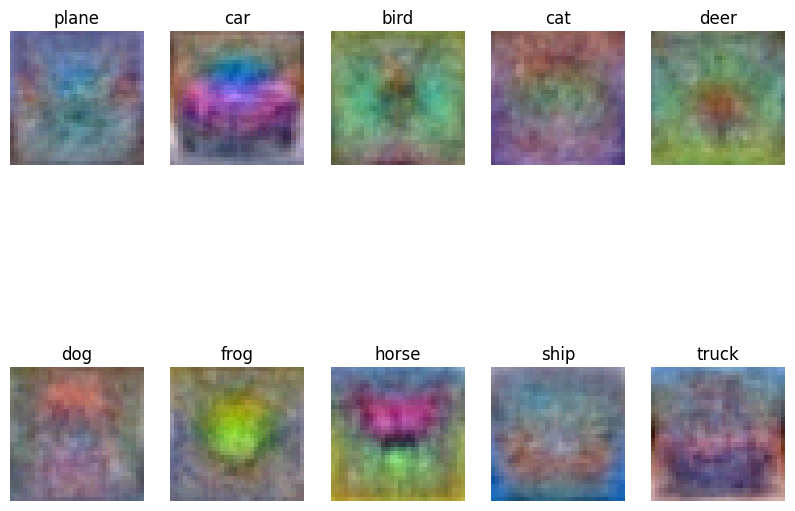

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])